In [1]:
from matplotlib import pyplot as plt
import numpy as np
import qutip as qt

In [2]:
def gaussian_ramp(t_rise, t_flat, t_down, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that rises, 
    stays flat, and then falls.

    Args:
    t_rise (float): The time at which the function reaches the amplitude.
    t_flat (float): The duration for which the function stays at the amplitude.
    t_down (float): The time it takes for the function to fall back to zero.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation for the Gaussian edges
    sigma_rise = t_rise / 3  # Adjust sigma to make the function start close to zero at t=0
    sigma_down = t_down / 3  # Similar adjustment for the falling edge

    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        t_start_flat = t_rise  # Time when flat region starts
        t_end_flat = t_rise + t_flat  # Time when flat region ends
        
        if t <= t_start_flat:
            # Gaussian rise centered at t_rise
            return amplitude * np.exp(-((t - t_start_flat)**2) / (2 * sigma_rise**2)) - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))
        elif t >= t_end_flat:
            # Gaussian fall centered at t_end_flat
            return amplitude * np.exp(-((t - t_end_flat)**2) / (2 * sigma_down**2)) - amplitude * np.exp(-((t_end_flat + t_down - t_end_flat)**2) / (2 * sigma_down**2))
        else:
            # Constant amplitude in the middle region
            return amplitude - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))

    return time_dependent_function

def linear_ramp(t_rise, t_flat, t_down, amplitude):
    """
    Creates a time-dependent function using a linear ramp that rises, 
    stays flat, and then falls.

    Args:
    t_rise (float): The time it takes for the function to rise to the amplitude.
    t_flat (float): The duration for which the function stays at the amplitude.
    t_down (float): The time it takes for the function to fall back to zero.
    amplitude (float): The maximum amplitude of the ramp.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        t_start_flat = t_rise  # Time when flat region starts
        t_end_flat = t_rise + t_flat  # Time when flat region ends
        
        if t <= t_start_flat:
            # Linear rise from 0 to amplitude
            return (t / t_rise) * amplitude
        elif t >= t_end_flat:
            # Linear fall from amplitude to 0
            return amplitude * (1 - (t - t_end_flat) / t_down)
        else:
            # Constant amplitude in the middle region
            return amplitude

    return time_dependent_function

def linear_ramp_frequency(t_rise, t_flat, t_down, initial_frequency, constant_frequency):
    """
    Creates a time-dependent function using a linear ramp that rises, 
    stays flat, and then falls.

    Args:
    t_rise (float): The time it takes for the function to rise to the amplitude.
    t_flat (float): The duration for which the function stays at the amplitude.
    t_down (float): The time it takes for the function to fall back to zero.
    amplitude (float): The maximum amplitude of the ramp.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        t_start_flat = t_rise  # Time when flat region starts
        t_end_flat = t_rise + t_flat  # Time when flat region ends
        
        if t <= t_start_flat:
            # Linear rise from 0 to amplitude
            return (t / t_rise) * (constant_frequency - initial_frequency) + initial_frequency
        elif t >= t_end_flat:
            # Linear fall from amplitude to 0
            return -((t-t_end_flat) / t_down) * (constant_frequency - initial_frequency) + constant_frequency
        else:
            # Constant amplitude in the middle region
            return constant_frequency

    return time_dependent_function


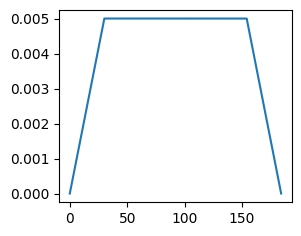

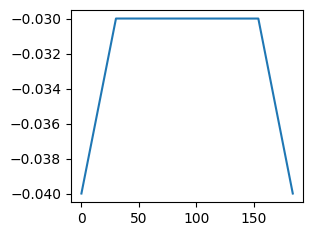

In [15]:

t_flat = 124
t_rise = 30
t_down = 30
amplitude = 5e-3*2*np.pi
func = linear_ramp(t_rise, t_flat, t_down, amplitude)
tlist = np.linspace(0, t_rise+t_flat+t_down, 10000)  # Cover ten periods
plt.figure(figsize=(3, 2.5))
plt.plot(tlist, [func(t)/2/np.pi for t in tlist])

omega = 6.03 * 2 * np.pi
omega1 = 6.06*2*np.pi
constant_frequency = omega - omega1
frquency_func = linear_ramp_frequency(t_rise, t_flat, t_down, constant_frequency-10e-3*2*np.pi, constant_frequency)
plt.figure(figsize=(3, 2.5))
plt.plot(tlist, [frquency_func(t)/2/np.pi for t in tlist])

lab frame

rotating frame

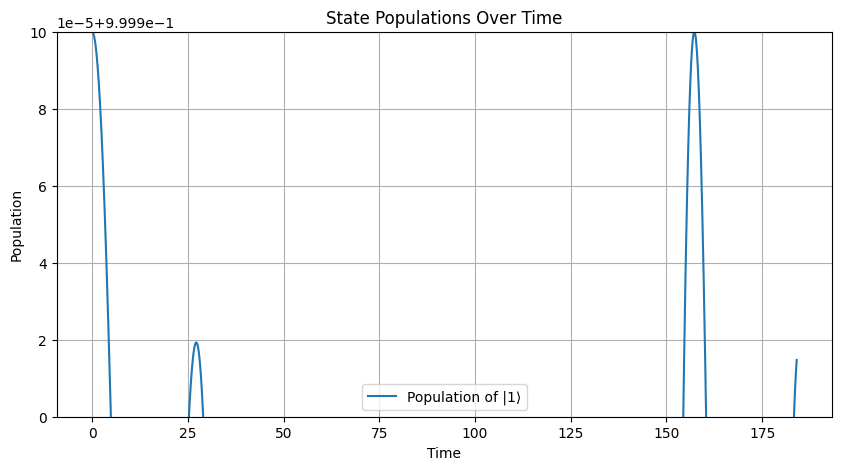

In [16]:
from system import *
T = (2*np.pi)/omega
args = {'w': omega,'w1':omega1}
psi0 = qt.basis(2, 0)
H0 = 0*qt.sigmaz()

Hc1 = qt.sigmax()
Hc2 = qt.num(2)
H = [H0, [Hc1, lambda t, args: func(t)/2],[Hc2,lambda t, args: frquency_func(t)]]
options = {"nsteps":100000, "rtol":1e-10, "atol":1e-10}

avgvalue = np.zeros(len(tlist))
# Use sesolve for consistency with previous code
result = qt.sesolve(H, psi0, tlist, args=args, options=options)
for i in range(len(tlist)):
    H_t = H0 + Hc1 * func(tlist[i])/2 + Hc2 * frquency_func(tlist[i])
    evals, U = np.linalg.eigh(H_t.full())
    evals, U = sort_eigenpairs(evals, U)
    ground_state = qt.Qobj(U[:,0])
    P = ground_state.dag() * result.states[i]
    avgvalue[i] = np.abs(result.states[i].dag() * P * result.states[i])**2

# Plot results
plt.figure(figsize=(10, 5))
# plt.plot(tlist, pop0_rwa, label="Population of |0⟩")
plt.plot(tlist, avgvalue, label="Population of |1⟩")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("State Populations Over Time")
plt.legend()
plt.grid(True)
plt.ylim(0.9999, 1)
plt.show()

In [14]:
avgvalue[-1]

np.float64(0.9998894100539054)

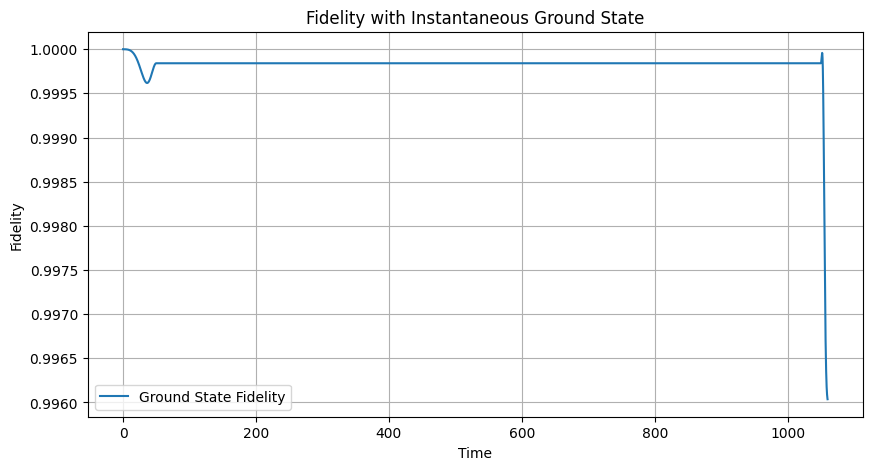

In [72]:
T = (2*np.pi)/omega
args = {'w': omega,'w1':omega1}
psi0 = qt.basis(2, 0)
H0 = (omega-omega1)/2*qt.sigmaz()
Hc = qt.sigmax()
H = [H0, [Hc, lambda t, args: func(t)/2]]
options = {"nsteps":100000, "rtol":1e-10, "atol":1e-10}
result = qt.sesolve(H, psi0, tlist, args=args, options=options)

# Calculate instantaneous eigenstates for each time point
fidelities = []
evecs_list = []  # Store all eigenvectors
for t, state in zip(tlist, result.states):
    # Construct instantaneous Hamiltonian
    H_t = H0 + Hc * func(t)/2
    # Get eigenvalues and eigenvectors
    evals, evecs = H_t.eigenstates()
    evecs_list.append(evecs)  # Store eigenvectors for this time point
    # Ground state is the eigenstate with lowest energy
    ground_state = evecs[0]
    # Calculate fidelity between evolved state and ground state
    fidelity = abs((ground_state.dag() * state))**2
    fidelities.append(fidelity)

# Plot fidelities vs time
plt.figure(figsize=(10, 5))
plt.plot(tlist, fidelities, label='Ground State Fidelity')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.title('Fidelity with Instantaneous Ground State')
plt.legend()
plt.grid(True)
plt.show()


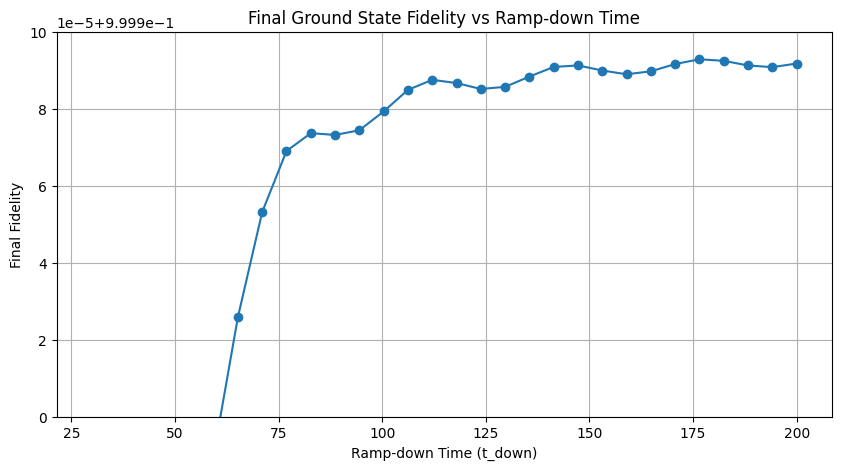

In [95]:
t_rise = 100
t_flat = 1000
amplitude = 5e-3*2*np.pi
T = (2*np.pi)/omega

# Define range of t_down values to test
t_down_values = np.linspace(30, 200, 30)  # Try 20 different t_down values
final_fidelities = []  # Store the final fidelity for each t_down

for t_down in t_down_values:
    # Create the pulse function for this t_down
    func = gaussian_ramp(t_rise, t_flat, t_down, amplitude)
    tlist = np.linspace(0, t_rise+t_flat+t_down, 10000)  # Cover ten periods
    # Setup Hamiltonian
    H0 = (omega-omega1)/2*qt.sigmaz()
    Hc = qt.sigmax()
    H = [H0, [Hc, lambda t, args: func(t)/2]]
    
    # Solve the dynamics
    result = qt.sesolve(H, qt.basis(2, 0), tlist, 
                        args={'w': omega, 'w1': omega1},
                        options={"nsteps": 100000, "rtol": 1e-10, "atol": 1e-10})

    # Calculate final fidelity with ground state
    final_state = result.states[-1]
    H_final = H0 + Hc * func(tlist[-1])/2
    ground_state = H_final.eigenstates()[1][0]
    final_fidelities.append(abs((ground_state.dag() * final_state))**2)

# Plot final fidelity vs t_down
plt.figure(figsize=(10, 5))
plt.plot(t_down_values, final_fidelities, 'o-')
plt.xlabel('Ramp-down Time (t_down)')
plt.ylabel('Final Fidelity')
plt.title('Final Ground State Fidelity vs Ramp-down Time')
plt.ylim(0.9999, 1.0)  # Set y-axis to start from 0.999
plt.grid(True)
plt.show()


In [94]:
max(final_fidelities)

0.9999987043370087

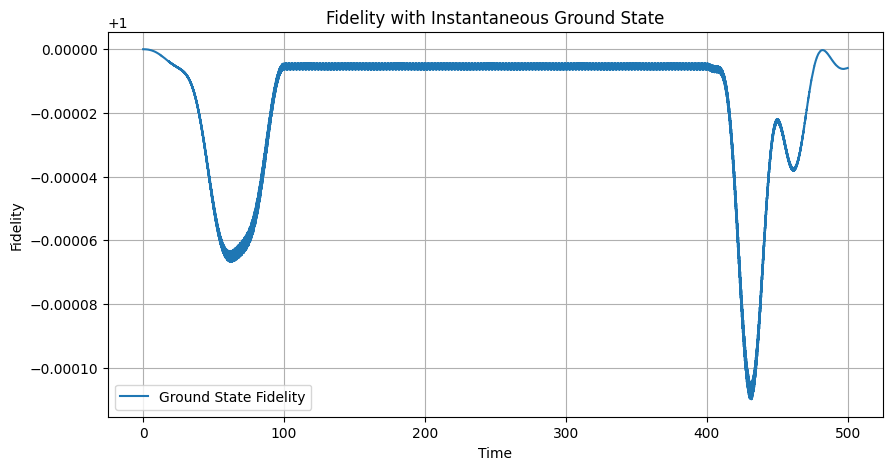

In [63]:
T = (2*np.pi)/omega
args = {'w': omega,'w1':omega1}
tlist = np.linspace(0, 500, 10000)  # Cover ten periods
psi0 = qt.basis(2, 0)
H0 = (omega)/2*qt.sigmaz()
Hc = qt.sigmax()
H = [H0, [Hc, lambda t, args: func(t)*np.cos(args['w1']*t)]]
options = {"nsteps":100000, "rtol":1e-10, "atol":1e-10}
result = qt.sesolve(H, psi0, tlist, args=args, options=options)
evecs_list = []  # Store all eigenvectors
# Calculate instantaneous eigenstates for each time point
fidelities = []
for i in range(len(tlist)):
    H_t = (omega-omega1)/2*qt.Qobj(np.array([[1,0],[0,-1]])) + Hc * func(tlist[i])/2
    # Get eigenvalues and eigenvectors
    evals, evecs = H_t.eigenstates()
    evecs_list.append(evecs)  # Store eigenvectors for this time point
    # Ground state is the eigenstate with lowest energy
    ground_state = evecs[0]
    # We don't need to recalculate evecs as they are given from the previous cell
    # Just use the corresponding time point's eigenvectors from evecs_list
    # Ground state is the eigenstate with lowest energy
    state = result.states[i]
    # Calculate fidelity between evolved state and ground state
    ground_state = evecs_list[i][0]
    U = (1j/2 * omega1 * tlist[i] * qt.sigmaz()).expm()
    fidelity = abs((ground_state.dag() * U * state))**2
    fidelities.append(fidelity)

# Plot fidelities vs time
plt.figure(figsize=(10, 5))
plt.plot(tlist, fidelities, label='Ground State Fidelity')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.title('Fidelity with Instantaneous Ground State')
plt.legend()
plt.grid(True)
plt.show()
